# Task 2 - Regularization
Team Members

*   Libin Kutty
*   Viju Sudhi
*   Ritu Gahir

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

# Cifar10 Dataset

In [3]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()

train_imgs = (train_imgs.astype(np.float32) / 255.).reshape((-1, 32, 32, 3))
train_lbls = train_lbls.astype(np.int32)

test_imgs = (test_imgs.astype(np.float32) / 255.).reshape((-1, 32, 32, 3))
test_lbls = test_lbls.astype(np.int32)

batch_size = 128

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls))

train_data = train_data.shuffle(train_imgs.shape[0])
train_data = train_data.batch(batch_size)
train_data = train_data.repeat(5)


test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls))
test_data = test_data.batch(batch_size)

170500096/170498071 [==============================] - 3s 0us/step


In [4]:
def train(model):
  step_graph = []
  loss_graph = []
  acc_graph = []
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  opt = tf.optimizers.Adam()

  for step, (img_batch, lbl_batch) in enumerate(train_data):
    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)

    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
      step_graph.append(step)
      loss_graph.append(xent)
      acc_graph.append(train_acc_metric.result())
      print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
      train_acc_metric.reset_states()
  
  return step_graph, loss_graph, acc_graph

In [5]:
def test(model):
  test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  for img_batch, lbl_batch in test_data:
    logits = model(img_batch)
    xent = loss_fn(lbl_batch, logits) 
    test_acc_metric(lbl_batch, logits)

  return test_acc_metric.result()


# Model 1

## Without Regularization

In [6]:
def model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

In [7]:
model_wo_reg = model()

step_wo, loss_wo, acc_wo = train(model_wo_reg)

Loss: 2.3003485202789307 Accuracy: 0.171875
Loss: 2.163759469985962 Accuracy: 0.21117188036441803
Loss: 2.0616493225097656 Accuracy: 0.3021875023841858
Loss: 2.1240010261535645 Accuracy: 0.3578124940395355
Loss: 2.0832700729370117 Accuracy: 0.38252824544906616
Loss: 2.0907211303710938 Accuracy: 0.39945313334465027
Loss: 1.989314079284668 Accuracy: 0.4488281309604645
Loss: 1.9464777708053589 Accuracy: 0.47343748807907104
Loss: 1.986847996711731 Accuracy: 0.4983532130718231
Loss: 1.980864405632019 Accuracy: 0.5060155987739563
Loss: 1.8950222730636597 Accuracy: 0.5407031178474426
Loss: 1.9737383127212524 Accuracy: 0.533203125
Loss: 1.9030314683914185 Accuracy: 0.5410916209220886
Loss: 1.8853037357330322 Accuracy: 0.5584375262260437
Loss: 1.8446935415267944 Accuracy: 0.5573437213897705
Loss: 1.8964955806732178 Accuracy: 0.557812511920929
Loss: 1.8579027652740479 Accuracy: 0.5885351300239563
Loss: 1.8757610321044922 Accuracy: 0.5904687643051147
Loss: 1.9107271432876587 Accuracy: 0.591484367

In [8]:
test_acc = []

In [9]:
test_wo = test(model_wo_reg)
print(test_wo)
test_acc.append(test_wo)

tf.Tensor(0.6018, shape=(), dtype=float32)


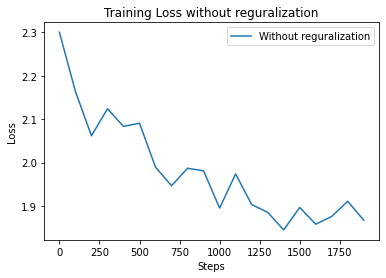

In [10]:
plt.plot(step_wo, loss_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss without reguralization')
plt.legend()
plt.show()

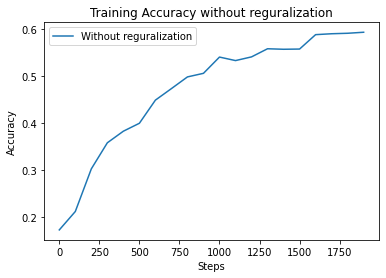

In [11]:
plt.plot(step_wo, acc_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy without reguralization')
plt.legend()
plt.show()

## L1 Regularization

In [12]:
def model_wL1():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), kernel_regularizer='l1', input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), kernel_regularizer='l1'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), kernel_regularizer='l1'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64, kernel_regularizer='l1'))
  #model.add(Activation('relu'))

  model.add(Dense(10, kernel_regularizer='l1'))
  model.add(Activation('softmax'))

  return model

In [13]:
model_w_l1 = model_wL1()

step_wl1, loss_wl1, acc_wl1 = train(model_w_l1)

Loss: 2.303072929382324 Accuracy: 0.0703125
Loss: 2.1451730728149414 Accuracy: 0.20937499403953552
Loss: 2.1525630950927734 Accuracy: 0.31593748927116394
Loss: 2.068732738494873 Accuracy: 0.37328124046325684
Loss: 2.055008888244629 Accuracy: 0.4094259738922119
Loss: 2.0252997875213623 Accuracy: 0.43867188692092896
Loss: 1.9808036088943481 Accuracy: 0.46117186546325684
Loss: 1.9514076709747314 Accuracy: 0.4642968773841858
Loss: 2.006201982498169 Accuracy: 0.4861982464790344
Loss: 1.966627836227417 Accuracy: 0.49609375
Loss: 1.9812653064727783 Accuracy: 0.5067187547683716
Loss: 1.9466511011123657 Accuracy: 0.520312488079071
Loss: 1.9570882320404053 Accuracy: 0.5300344824790955
Loss: 1.9473743438720703 Accuracy: 0.5487499833106995
Loss: 1.8711578845977783 Accuracy: 0.5514843463897705
Loss: 1.9422101974487305 Accuracy: 0.5608593821525574
Loss: 1.883716344833374 Accuracy: 0.566656231880188
Loss: 1.8311705589294434 Accuracy: 0.5873437523841858
Loss: 1.7825596332550049 Accuracy: 0.59531247615

In [14]:
test_wl1 = test(model_w_l1)
print(test_wl1)
test_acc.append(test_wl1)

tf.Tensor(0.5874, shape=(), dtype=float32)


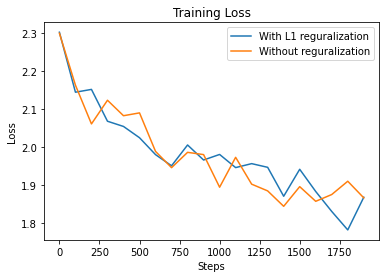

In [15]:
plt.plot(step_wl1, loss_wl1, label="With L1 reguralization")
plt.plot(step_wo, loss_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss')
plt.legend()
plt.show()

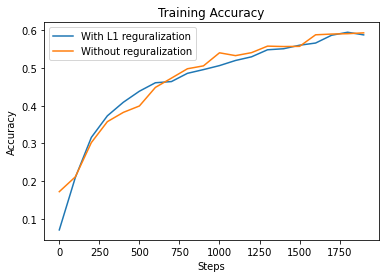

In [16]:
plt.plot(step_wl1, acc_wl1, label="With L1 reguralization")
plt.plot(step_wo, acc_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.legend()
plt.show()

## L2 Regularization

In [17]:
def model_wL2():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), kernel_regularizer='l2', input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), kernel_regularizer='l2'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), kernel_regularizer='l2'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64, kernel_regularizer='l2'))
  #model.add(Activation('relu'))

  model.add(Dense(10, kernel_regularizer='l2'))
  model.add(Activation('softmax'))

  return model

In [18]:
model_w_l2 = model_wL2()

step_wl2, loss_wl2, acc_wl2 = train(model_w_l2)

Loss: 2.3028340339660645 Accuracy: 0.0625
Loss: 2.1602253913879395 Accuracy: 0.23007813096046448
Loss: 2.0759119987487793 Accuracy: 0.3341406285762787
Loss: 2.086632490158081 Accuracy: 0.3888281285762787
Loss: 2.020501136779785 Accuracy: 0.4087201952934265
Loss: 2.1097476482391357 Accuracy: 0.4225781261920929
Loss: 2.026658058166504 Accuracy: 0.4429687559604645
Loss: 1.9851796627044678 Accuracy: 0.46632811427116394
Loss: 1.970158338546753 Accuracy: 0.4799247086048126
Loss: 1.9825786352157593 Accuracy: 0.4868749976158142
Loss: 1.9788527488708496 Accuracy: 0.49992188811302185
Loss: 1.857563853263855 Accuracy: 0.5236718654632568
Loss: 1.8922094106674194 Accuracy: 0.5297208428382874
Loss: 1.960136890411377 Accuracy: 0.5421093702316284
Loss: 1.840569019317627 Accuracy: 0.557421863079071
Loss: 1.8758971691131592 Accuracy: 0.5595312714576721
Loss: 1.8758790493011475 Accuracy: 0.5752038955688477
Loss: 1.8489406108856201 Accuracy: 0.5928124785423279
Loss: 1.873821496963501 Accuracy: 0.58984375


In [19]:
test_wl2 = test(model_w_l2)
print(test_wl2)
test_acc.append(test_wl2)

tf.Tensor(0.5954, shape=(), dtype=float32)


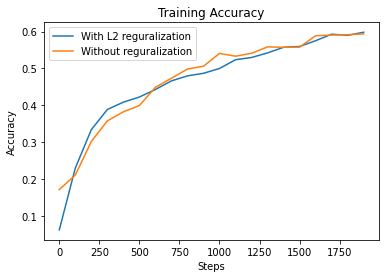

In [20]:
plt.plot(step_wl2, acc_wl2, label="With L2 reguralization")
plt.plot(step_wo, acc_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.legend()
plt.show()

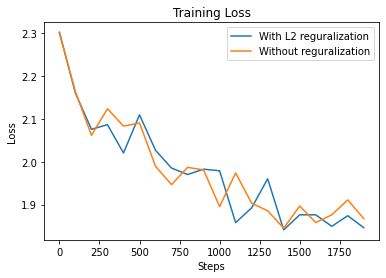

In [21]:
plt.plot(step_wl2, loss_wl2, label="With L2 reguralization")
plt.plot(step_wo, loss_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss')
plt.legend()
plt.show()

## Dropout

In [22]:
def model_wdropout():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

In [23]:
model_w_dropout = model_wdropout()

step_wdo, loss_wdo, acc_wdo = train(model_w_dropout)

Loss: 2.3037238121032715 Accuracy: 0.09375
Loss: 2.1244163513183594 Accuracy: 0.23468750715255737
Loss: 2.070737361907959 Accuracy: 0.3446093797683716
Loss: 2.1312248706817627 Accuracy: 0.38695311546325684
Loss: 2.090484857559204 Accuracy: 0.4244040250778198
Loss: 1.9789643287658691 Accuracy: 0.4510156214237213
Loss: 1.9785720109939575 Accuracy: 0.44921875
Loss: 1.990425705909729 Accuracy: 0.4803124964237213
Loss: 1.8676408529281616 Accuracy: 0.49419698119163513
Loss: 1.9352668523788452 Accuracy: 0.5111718773841858
Loss: 1.8895783424377441 Accuracy: 0.5223437547683716
Loss: 1.9059233665466309 Accuracy: 0.5282812714576721
Loss: 1.960768699645996 Accuracy: 0.5364648699760437
Loss: 1.9282610416412354 Accuracy: 0.5445312261581421
Loss: 1.9030799865722656 Accuracy: 0.5603125095367432
Loss: 1.8981457948684692 Accuracy: 0.5749218463897705
Loss: 1.8553509712219238 Accuracy: 0.5690087676048279
Loss: 1.871634840965271 Accuracy: 0.5930469036102295
Loss: 1.9082629680633545 Accuracy: 0.586640596389

In [24]:
test_wdo = test(model_w_dropout)
print(test_wdo)
test_acc.append(test_wdo)

tf.Tensor(0.5845, shape=(), dtype=float32)


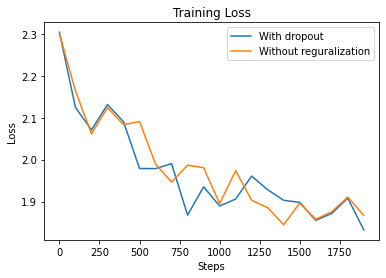

In [25]:
plt.plot(step_wdo, loss_wdo, label="With dropout")
plt.plot(step_wo, loss_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss')
plt.legend()
plt.show()

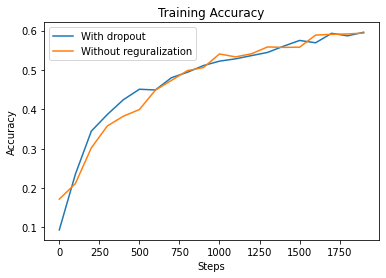

In [26]:
plt.plot(step_wdo, acc_wdo, label="With dropout")
plt.plot(step_wo, acc_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.legend()
plt.show()

## Data Augmentation

In [27]:
def model_wDA():
  data_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  ])

  model = Sequential()

  model.add(data_augmentation)

  model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

In [28]:
model_w_da = model_wDA()

step_wda, loss_wda, acc_wda = train(model_w_da)

Loss: 2.302931070327759 Accuracy: 0.1015625
Loss: 2.258162260055542 Accuracy: 0.17624999582767487
Loss: 2.2024786472320557 Accuracy: 0.2606250047683716
Loss: 2.224828004837036 Accuracy: 0.29765623807907104
Loss: 2.1891143321990967 Accuracy: 0.3108532130718231
Loss: 2.164702892303467 Accuracy: 0.32640624046325684
Loss: 2.089010715484619 Accuracy: 0.32875001430511475
Loss: 2.12868595123291 Accuracy: 0.34187498688697815
Loss: 2.0548791885375977 Accuracy: 0.34778857231140137
Loss: 2.0580549240112305 Accuracy: 0.3528124988079071
Loss: 2.071584463119507 Accuracy: 0.35648438334465027
Loss: 2.023411989212036 Accuracy: 0.35640624165534973
Loss: 2.0514087677001953 Accuracy: 0.370138019323349
Loss: 2.136766195297241 Accuracy: 0.37328124046325684
Loss: 2.0909488201141357 Accuracy: 0.37117186188697815
Loss: 2.035555362701416 Accuracy: 0.3772656321525574
Loss: 2.1025476455688477 Accuracy: 0.39052698016166687
Loss: 2.0337791442871094 Accuracy: 0.384765625
Loss: 2.065614938735962 Accuracy: 0.386953115

In [29]:
test_wda = test(model_w_da)
print(test_wda)
test_acc.append(test_wda)

tf.Tensor(0.3877, shape=(), dtype=float32)


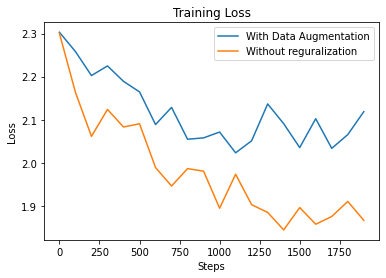

In [30]:
plt.plot(step_wda, loss_wda, label="With Data Augmentation")
plt.plot(step_wo, loss_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss')
plt.legend()
plt.show()

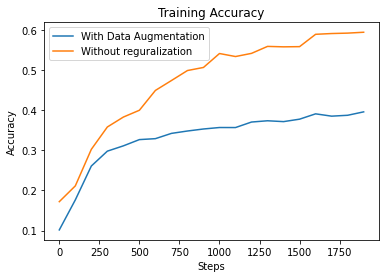

In [31]:
plt.plot(step_wda, acc_wda, label="With Data Augmentation")
plt.plot(step_wo, acc_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.legend()
plt.show()

## Comparision between Regularization technique

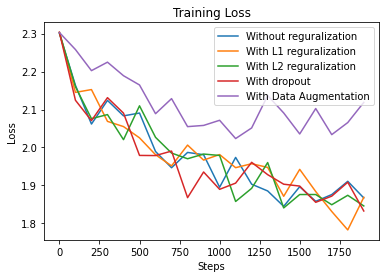

In [32]:
plt.plot(step_wo, loss_wo, label="Without reguralization")
plt.plot(step_wl1, loss_wl1, label="With L1 reguralization")
plt.plot(step_wl2, loss_wl2, label="With L2 reguralization")
plt.plot(step_wdo, loss_wdo, label="With dropout")
plt.plot(step_wda, loss_wda, label="With Data Augmentation")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss')
plt.legend()
plt.show()

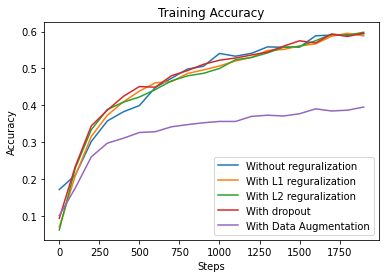

In [33]:
plt.plot(step_wo, acc_wo, label="Without reguralization")
plt.plot(step_wl1, acc_wl1, label="With L1 reguralization")
plt.plot(step_wl2, acc_wl2, label="With L2 reguralization")
plt.plot(step_wdo, acc_wdo, label="With dropout")
plt.plot(step_wda, acc_wda, label="With Data Augmentation")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.legend()
plt.show()

In [34]:
test_acc

[<tf.Tensor: shape=(), dtype=float32, numpy=0.6018>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5874>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5954>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5845>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3877>]

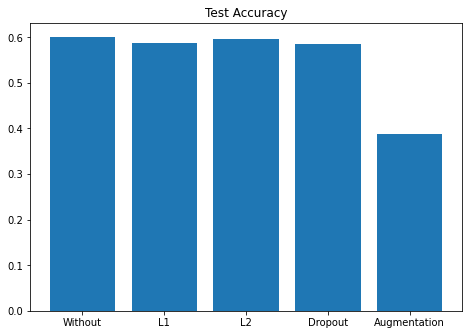

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
reg = ['Without', 'L1', 'L2', 'Dropout', 'Augmentation']
ax.bar(reg, test_acc)
plt.title('Test Accuracy')
plt.show()

# Model 2

## Without Regularization

In [36]:
def model2():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

  model.add(Dense(10, activation='softmax'))

  return model

In [37]:
model2_wo = model2()

step2_wo, loss2_wo, acc2_wo = train(model2_wo)

Loss: 2.301835536956787 Accuracy: 0.1171875
Loss: 2.1437578201293945 Accuracy: 0.24648436903953552
Loss: 2.0779850482940674 Accuracy: 0.330078125
Loss: 2.1802868843078613 Accuracy: 0.35374999046325684
Loss: 2.134477138519287 Accuracy: 0.38315558433532715
Loss: 2.027904748916626 Accuracy: 0.41187500953674316
Loss: 1.9849181175231934 Accuracy: 0.4352343678474426
Loss: 2.019218683242798 Accuracy: 0.4449999928474426
Loss: 1.9867115020751953 Accuracy: 0.45843788981437683
Loss: 2.031886577606201 Accuracy: 0.47789061069488525
Loss: 1.9841364622116089 Accuracy: 0.5121874809265137
Loss: 1.9140114784240723 Accuracy: 0.5053906440734863
Loss: 1.941434383392334 Accuracy: 0.5232904553413391
Loss: 1.8391443490982056 Accuracy: 0.5453906059265137
Loss: 1.9362807273864746 Accuracy: 0.5475000143051147
Loss: 1.8561985492706299 Accuracy: 0.5445312261581421
Loss: 1.9043521881103516 Accuracy: 0.543679416179657
Loss: 1.8882769346237183 Accuracy: 0.5738281011581421
Loss: 1.8723986148834229 Accuracy: 0.57226562

In [38]:
test2_acc = []

In [39]:
test2_wo = test(model2_wo)
print(test2_wo)
test2_acc.append(test2_wo)

tf.Tensor(0.5559, shape=(), dtype=float32)


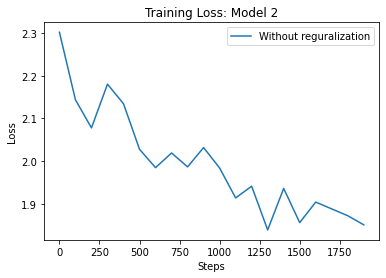

In [40]:
plt.plot(step2_wo, loss2_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss: Model 2')
plt.legend()
plt.show()

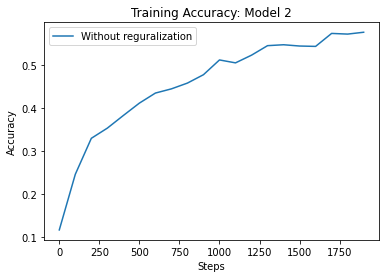

In [41]:
plt.plot(step2_wo, acc2_wo, label="Without reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy: Model 2')
plt.legend()
plt.show()

## L1 Regularization

In [42]:
def model2_wL1():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1'))

  model.add(Dense(10, activation='softmax', kernel_regularizer='l1'))

  return model

In [43]:
model2_w_l1 = model2_wL1()

step2_wl1, loss2_wl1, acc2_wl1 = train(model2_w_l1)

Loss: 2.312793254852295 Accuracy: 0.09375
Loss: 2.3439626693725586 Accuracy: 0.09789062291383743
Loss: 2.3517751693725586 Accuracy: 0.10148437321186066
Loss: 2.3361501693725586 Accuracy: 0.09898437559604645
Loss: 2.3752126693725586 Accuracy: 0.10225846618413925
Loss: 2.3830251693725586 Accuracy: 0.09664062410593033
Loss: 2.3674001693725586 Accuracy: 0.10304687172174454
Loss: 2.3439626693725586 Accuracy: 0.1028124988079071
Loss: 2.3439626693725586 Accuracy: 0.09833751618862152
Loss: 2.3517751693725586 Accuracy: 0.10203125327825546
Loss: 2.3361501693725586 Accuracy: 0.09781250357627869
Loss: 2.3517751693725586 Accuracy: 0.09726562350988388
Loss: 2.3674001693725586 Accuracy: 0.10092534869909286
Loss: 2.3439626693725586 Accuracy: 0.09906250238418579
Loss: 2.3283376693725586 Accuracy: 0.10343749821186066
Loss: 2.3439626693725586 Accuracy: 0.10015624761581421
Loss: 2.3049001693725586 Accuracy: 0.10037641227245331
Loss: 2.3595876693725586 Accuracy: 0.09906250238418579
Loss: 2.3986501693725586

In [44]:
test2_wl1 = test(model2_w_l1)
print(test2_wl1)
test2_acc.append(test2_wl1)

tf.Tensor(0.1, shape=(), dtype=float32)


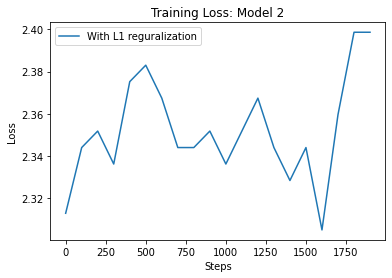

In [45]:
plt.plot(step2_wl1, loss2_wl1, label="With L1 reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss: Model 2')
plt.legend()
plt.show()

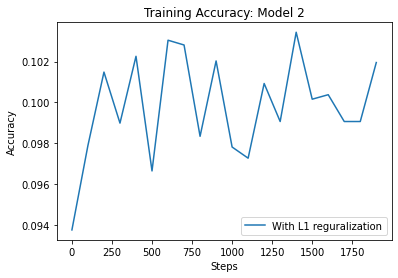

In [46]:
plt.plot(step2_wl1, acc2_wl1, label="With L1 reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy: Model 2')
plt.legend()
plt.show()

## L2 Regularization

In [47]:
def model2_wL2():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))

  model.add(Dense(10, activation='softmax', kernel_regularizer='l2'))

  return model

In [48]:
model2_w_l2 = model2_wL2()

step2_wl2, loss2_wl2, acc2_wl2 = train(model2_w_l2)

Loss: 2.2989256381988525 Accuracy: 0.140625
Loss: 2.1322035789489746 Accuracy: 0.21406249701976776
Loss: 2.223966360092163 Accuracy: 0.2965624928474426
Loss: 2.124345541000366 Accuracy: 0.3363281190395355
Loss: 1.987937331199646 Accuracy: 0.36582496762275696
Loss: 1.9716072082519531 Accuracy: 0.40812501311302185
Loss: 2.0195093154907227 Accuracy: 0.42867186665534973
Loss: 1.9444797039031982 Accuracy: 0.46617186069488525
Loss: 1.9624592065811157 Accuracy: 0.49772584438323975
Loss: 1.949556827545166 Accuracy: 0.5182031393051147
Loss: 1.9284340143203735 Accuracy: 0.5492968559265137
Loss: 1.8886783123016357 Accuracy: 0.5478906035423279
Loss: 1.8623778820037842 Accuracy: 0.5646957159042358
Loss: 1.8453131914138794 Accuracy: 0.5971093773841858
Loss: 1.8689864873886108 Accuracy: 0.6108593940734863
Loss: 1.8109204769134521 Accuracy: 0.6106250286102295
Loss: 1.8275319337844849 Accuracy: 0.6171581149101257
Loss: 1.822648286819458 Accuracy: 0.6383593678474426
Loss: 1.7778315544128418 Accuracy: 0.

In [49]:
test2_wl2 = test(model2_w_l2)
print(test2_wl2)
test2_acc.append(test2_wl2)

tf.Tensor(0.649, shape=(), dtype=float32)


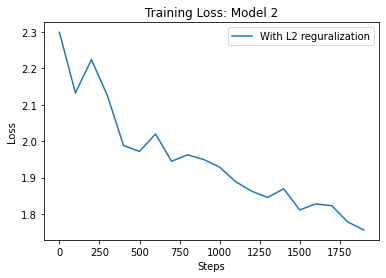

In [50]:
plt.plot(step2_wl2, loss2_wl2, label="With L2 reguralization")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss: Model 2')
plt.legend()
plt.show()

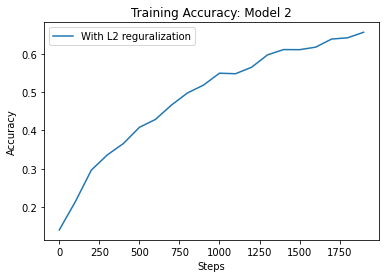

In [51]:
plt.plot(step2_wl2, acc2_wl2, label="With L2 reguralization")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy: Model 2')
plt.legend()
plt.show()

## Dropout

In [52]:
def model2_wDO():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  return model

In [53]:
model2_w_do = model2_wDO()

step2_wdo, loss2_wdo, acc2_wdo = train(model2_w_do)

Loss: 2.2991979122161865 Accuracy: 0.125
Loss: 2.3361501693725586 Accuracy: 0.0989062488079071
Loss: 2.3361501693725586 Accuracy: 0.0989062488079071
Loss: 2.3674001693725586 Accuracy: 0.10039062798023224
Loss: 2.3830251693725586 Accuracy: 0.10194478929042816
Loss: 2.3439626693725586 Accuracy: 0.1015625
Loss: 2.3986501693725586 Accuracy: 0.09828124940395355
Loss: 2.3752126693725586 Accuracy: 0.09726562350988388
Loss: 2.3439626693725586 Accuracy: 0.10304266214370728
Loss: 2.3595876693725586 Accuracy: 0.09609375149011612
Loss: 2.3439626693725586 Accuracy: 0.10242187231779099
Loss: 2.3517751693725586 Accuracy: 0.09875000268220901
Loss: 2.3674001693725586 Accuracy: 0.10100376605987549
Loss: 2.3674001693725586 Accuracy: 0.10007812827825546
Loss: 2.3361501693725586 Accuracy: 0.10218749940395355
Loss: 2.3986501693725586 Accuracy: 0.09624999761581421
Loss: 2.3517751693725586 Accuracy: 0.09872961044311523
Loss: 2.3752126693725586 Accuracy: 0.10382812470197678
Loss: 2.4142751693725586 Accuracy: 0

In [54]:
test2_wdo = test(model2_w_do)
print(test2_wdo)
test2_acc.append(test2_wdo)

tf.Tensor(0.1, shape=(), dtype=float32)


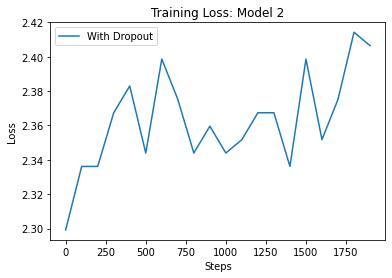

In [55]:
plt.plot(step2_wdo, loss2_wdo, label="With Dropout")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss: Model 2')
plt.legend()
plt.show()

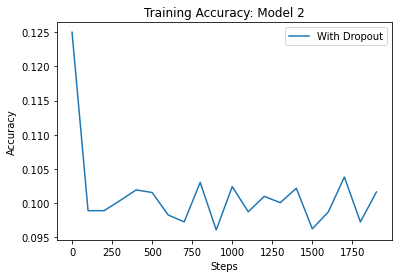

In [56]:
plt.plot(step2_wdo, acc2_wdo, label="With Dropout")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy: Model 2')
plt.legend()
plt.show()

## Data Augmentation

In [57]:
def model2_wDA():
  data_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  ])

  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  
  model.add(Dense(10, activation='softmax'))

  return model

In [58]:
model2_w_da = model2_wDA()

step2_wda, loss2_wda, acc2_wda = train(model2_w_da)

Loss: 2.308450937271118 Accuracy: 0.078125
Loss: 2.2148056030273438 Accuracy: 0.23078125715255737
Loss: 2.1629180908203125 Accuracy: 0.31421875953674316
Loss: 2.091488838195801 Accuracy: 0.3696874976158142
Loss: 2.092623233795166 Accuracy: 0.4215025007724762
Loss: 1.9818366765975952 Accuracy: 0.44359374046325684
Loss: 1.955460786819458 Accuracy: 0.4682031273841858
Loss: 1.9829134941101074 Accuracy: 0.47484374046325684
Loss: 1.8936127424240112 Accuracy: 0.5020388960838318
Loss: 1.972093105316162 Accuracy: 0.5360937714576721
Loss: 1.929497480392456 Accuracy: 0.5451562404632568
Loss: 1.8582704067230225 Accuracy: 0.5464062690734863
Loss: 1.8527789115905762 Accuracy: 0.5593632459640503
Loss: 1.824121356010437 Accuracy: 0.5884374976158142
Loss: 1.784472942352295 Accuracy: 0.5963281393051147
Loss: 1.878248929977417 Accuracy: 0.6064062714576721
Loss: 1.8703691959381104 Accuracy: 0.6169228553771973
Loss: 1.8208606243133545 Accuracy: 0.6288281083106995
Loss: 1.7346446514129639 Accuracy: 0.632578

In [59]:
test2_wda = test(model2_w_da)
print(test2_wda)
test2_acc.append(test2_wda)

tf.Tensor(0.6403, shape=(), dtype=float32)


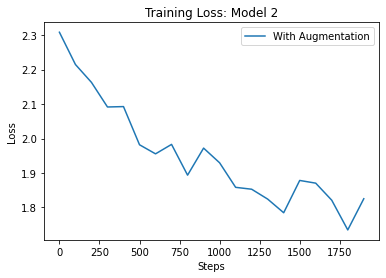

In [60]:
plt.plot(step2_wda, loss2_wda, label="With Augmentation")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss: Model 2')
plt.legend()
plt.show()

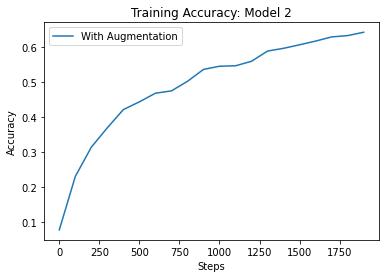

In [61]:
plt.plot(step2_wda, acc2_wda, label="With Augmentation")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy: Model 2')
plt.legend()
plt.show()

## Comparision between Regularization Technique

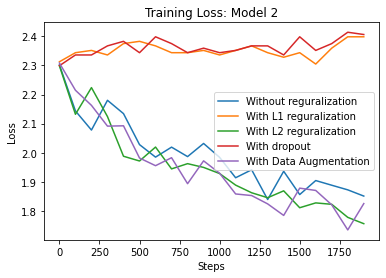

In [62]:
plt.plot(step2_wo, loss2_wo, label="Without reguralization")
plt.plot(step2_wl1, loss2_wl1, label="With L1 reguralization")
plt.plot(step2_wl2, loss2_wl2, label="With L2 reguralization")
plt.plot(step2_wdo, loss2_wdo, label="With dropout")
plt.plot(step2_wda, loss2_wda, label="With Data Augmentation")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss: Model 2')
plt.legend()
plt.show()

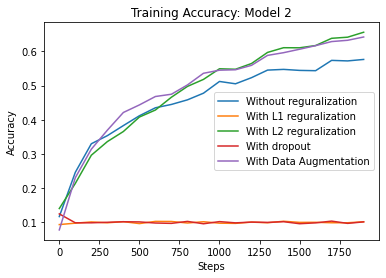

In [63]:
plt.plot(step2_wo, acc2_wo, label="Without reguralization")
plt.plot(step2_wl1, acc2_wl1, label="With L1 reguralization")
plt.plot(step2_wl2, acc2_wl2, label="With L2 reguralization")
plt.plot(step2_wdo, acc2_wdo, label="With dropout")
plt.plot(step2_wda, acc2_wda, label="With Data Augmentation")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy: Model 2')
plt.legend()
plt.show()

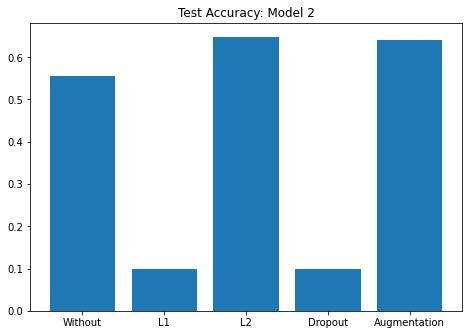

In [64]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
reg = ['Without', 'L1', 'L2', 'Dropout', 'Augmentation']
ax.bar(reg, test2_acc)
plt.title('Test Accuracy: Model 2')
plt.show()

# Conclusion

---

*   With Model 1, L1 regularizer worked better
*   With Model 2, regularizer didnt improve much


